# Markov Chain

In [70]:
import glob
import pandas as pd
import re 
import numpy as np
from discreteMarkovChain import markovChain
import scipy.stats
import matplotlib.pyplot as plt
import sklearn.metrics

## Loading the data


In [3]:
phrase_functions_books_direction = glob.glob("Data/phrase_functions/*.txt")

#Sample
phrase_functions_books_direction[:3]

['Data/phrase_functions\\phrase_functions_Chronica_I.txt',
 'Data/phrase_functions\\phrase_functions_Chronica_II.txt',
 'Data/phrase_functions\\phrase_functions_Deuteronomium.txt']

In [4]:
books = []
book_names = []
for book in phrase_functions_books_direction:
    bookFunctions = []
    with open(book) as inputfile:
        for line in inputfile:
            bookFunctions.append(line.strip().split(' '))
    books.append(bookFunctions) 
    bookname = re.search('phrase_functions_(.*?).txt', book).group(1)
    book_names.append(bookname)

#Sample
bookindex = 0
print(book_names[bookindex])
print(books[bookindex][:3])

Chronica_I
[['Conj', 'Pred', 'Subj', 'Objc'], ['Subj', 'PreC'], ['Subj', 'PreC']]


In [5]:
uniqueFunctions_book = []
for book in books:
    setFunctions = set()
    for sentence in book:
        for function in sentence:
            setFunctions.add(function)
    uniqueFunctions = sorted(list(setFunctions))
    uniqueFunctions_book.append(uniqueFunctions)

#Sample
bookindex = 0
print(book_names[bookindex])
print(uniqueFunctions_book[bookindex]) 

Chronica_I
['Adju', 'Cmpl', 'Conj', 'Loca', 'Modi', 'Nega', 'Objc', 'PreC', 'PreO', 'PreS', 'Pred', 'Rela', 'Subj', 'Time']


# Probability That a Function is Followed by Another

First, we count the frequency that a word is followed by another. This means that for a clause containing "FunctionA, FunctionB, FunctionC," we say that FunctionA --> FunctionB is one occurence of going from A to B. Then, we do the same for Function B -> Function C. A Clause always needs to start, so Clause-end indicates we go from nothing to the first function or when the clause ends with a function we say we end the clause.

In [61]:
df_M = []

for index,book in enumerate(books):
    unique_functions = uniqueFunctions_book[index]
    nuf = len(unique_functions)+1
    transitionMatrix = np.zeros((nuf,nuf))
    transitionNodes = ["CLAUSE-END"] +  unique_functions
    
    # count transitions using bigrams
    for sentence in book:
        transitionMatrix[0][transitionNodes.index(sentence[0])]+=1
        for i in range(0,len(sentence)-1):
            transitionMatrix[transitionNodes.index(sentence[i])][transitionNodes.index(sentence[i+1])]+=1        
        transitionMatrix[transitionNodes.index(sentence[-1])][0]+=1 # clause-end
    
    dfTransition = pd.DataFrame(transitionMatrix, columns = transitionNodes) # convert to dataframe

    dfTransition["Index"] = pd.Series(transitionNodes, index=dfTransition.index) # add row labels
    dfTransition = dfTransition.set_index("Index")
    dfTransition["Sum"]= dfTransition.sum(1) # add sum col
    df_M.append(dfTransition)

#Sample
bookindex = 0
print(book_names[bookindex])
df_M[bookindex]

Chronica_I


,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time,Sum
Index,,,,,,,,,,,,,,,,
CLAUSE-END,0.0,19.0,30.0,828.0,1.0,2.0,3.0,6.0,74.0,11.0,4.0,73.0,64.0,132.0,3.0,1250.0
Adju,135.0,23.0,21.0,0.0,1.0,0.0,0.0,25.0,4.0,0.0,0.0,9.0,0.0,19.0,4.0,241.0
Cmpl,265.0,33.0,21.0,0.0,5.0,1.0,2.0,28.0,6.0,0.0,0.0,7.0,0.0,35.0,11.0,414.0
Conj,0.0,27.0,17.0,1.0,3.0,3.0,10.0,37.0,42.0,46.0,0.0,480.0,0.0,162.0,1.0,829.0
Loca,26.0,4.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,40.0
Modi,8.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,4.0,0.0,5.0,1.0,24.0
Nega,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,2.0,0.0,20.0
Objc,211.0,35.0,48.0,0.0,11.0,2.0,1.0,5.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,327.0
PreC,295.0,39.0,28.0,0.0,4.0,1.0,0.0,17.0,0.0,0.0,0.0,1.0,0.0,26.0,4.0,415.0


## Transition probabilities

In [63]:
df_prob_M = []
for df in df_M:
    df1 = df.loc[:,"CLAUSE-END":"Time"].div(df["Sum"], axis=0)
    df_prob_M.append(df1)

#Sample
bookindex = 0
print(book_names[bookindex])
df_prob_M[bookindex].round(3)

Chronica_I


,CLAUSE-END,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,PreO,PreS,Pred,Rela,Subj,Time
Index,,,,,,,,,,,,,,,
CLAUSE-END,0.000,0.015,0.024,0.662,0.001,0.002,0.002,0.005,0.059,0.009,0.003,0.058,0.051,0.106,0.002
Adju,0.560,0.095,0.087,0.000,0.004,0.000,0.000,0.104,0.017,0.000,0.000,0.037,0.000,0.079,0.017
Cmpl,0.640,0.080,0.051,0.000,0.012,0.002,0.005,0.068,0.014,0.000,0.000,0.017,0.000,0.085,0.027
Conj,0.000,0.033,0.021,0.001,0.004,0.004,0.012,0.045,0.051,0.055,0.000,0.579,0.000,0.195,0.001
Loca,0.650,0.100,0.025,0.000,0.025,0.000,0.000,0.075,0.000,0.000,0.000,0.050,0.000,0.050,0.025
Modi,0.333,0.000,0.042,0.000,0.000,0.000,0.000,0.083,0.125,0.000,0.000,0.167,0.000,0.208,0.042
Nega,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.900,0.000,0.100,0.000
Objc,0.645,0.107,0.147,0.000,0.034,0.006,0.003,0.015,0.000,0.000,0.000,0.031,0.000,0.000,0.012
PreC,0.711,0.094,0.067,0.000,0.010,0.002,0.000,0.041,0.000,0.000,0.000,0.002,0.000,0.063,0.010


Here the tendency of the Hebrew narrative verb to shape its clause environment really shows. That verb form, called the *wayyiqtol* ("vay-yiqtōl"), typically comprises a majority of the verb forms in narration. It does two things to the clause specifically, as confirmed by the data we see here:

1. Inserts a conjunction at the beginning of the clause ("And" or waw), which is inherent to the verb form itself. It is the "W" in the *wayyiqtol*. Note that the conjunction does not occur at clause-end in our sample.
2. Since this conjunction (waw) is inherent to the verb form and also because it connects the clause to the preceding clauses, there can be no intervening subjects between the conjunction and the core of the verb, e.g. W + Subject + core_yiqtol_verb.

The data confirms in Genesis these known tendencies about Biblical Hebrew narrative. The conjunction switches to the predicate in 83% of instances it is used in our sample. 

There are some interesting results. Complement elements (adverbs that give extra or necessary information) tend to occur at clause-end.

`Adju` -> `END` (66%), <br> 
`Cmpl` -> `END` (73%), <br>
`Loca`-> `END` (70%), <br>
`Modi` -> `END` (64%), <br>
`Time` -> `END` (73%).

The tendency for the `Time` function phrase observed in our sample is also discussed in the literature (1, 2).

These are the strong tendencies that we see here. But what about the smaller ratios? It may be that these more "movable" elements become even more important for our investigation into the change of the language through time. That would especially be so if we find that the broader tendencies of the two dated-sources are the same, but the subtle tendencies different.

## Markov Chain Steady State probabilities

In [65]:
df_MC_STP = []
for index,df in enumerate(df_prob_M):
    P = np.matrix(df.as_matrix())
    mc = markovChain(P)
    mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
    data = [df.columns.values.tolist(),list(mc.pi)]
    dfSS = pd.DataFrame(np.matrix(data).transpose(),columns = ["Function","Prob_"+book_names[index]])
    df_MC_STP.append(dfSS)

#Sample
bookindex = 5
print(book_names[bookindex])
df_MC_STP[bookindex]
    

Esther


,Function,Prob_Esther
0,CLAUSE-END,0.240597345133
1,Adju,0.033185840708
2,Cmpl,0.114491150442
3,Conj,0.154867256637
4,Loca,0.00608407079646
5,Modi,0.00442477876106
6,Nega,0.00553097345133
7,Objc,0.0613938053097
8,PreC,0.0464601769912
9,PreO,0.00995575221239


In [83]:
df_probs = df_MC_STP[0]
for i in range(1,len(book_names)):
    df_probs = pd.merge(df_MC_STP[i],df_probs, on='Function', how="outer")
df_probs = df_probs.fillna(0.0)
df_probs = df_probs.set_index("Function")
df_probs

,Prob_Samuel_II,Prob_Samuel_I,Prob_Reges_II,Prob_Reges_I,Prob_Nehemia,Prob_Leviticus,Prob_LBH,Prob_Judices,Prob_Josua,Prob_Genesis,Prob_Exodus,Prob_Esther,Prob_Esra,Prob_EBH,Prob_Deuteronomium,Prob_Chronica_II,Prob_Chronica_I
Function,,,,,,,,,,,,,,,,,
CLAUSE-END,0.23872906827,0.240282685512,0.246087834427,0.247114902158,0.252081998719,0.236524537409,0.239572192513,0.238628411477,0.238722134457,0.242597754841,0.238627889635,0.240597345133,0.261173184358,0.240567765568,0.244799225931,0.239346434091,0.246256895193
Adju,0.0144554172034,0.00854895702724,0.0190560323069,0.0210737581535,0.0269058295964,0.0144810941271,0.0326203208556,0.0128761371589,0.0200105318589,0.0125065923303,0.0250559284116,0.033185840708,0.0551675977654,0.0162545787546,0.0280599903241,0.0413998675204,0.0474783293932
Cmpl,0.105338485759,0.101333637296,0.101337708228,0.0928248871049,0.0919282511211,0.12389380531,0.111764705882,0.111826452064,0.115850447604,0.0918405786182,0.083072334079,0.114491150442,0.0754189944134,0.090521978022,0.106434446057,0.09461249724,0.0815602836879
Conj,0.194933447832,0.197537900376,0.184628975265,0.172353236327,0.164317745035,0.174577634755,0.154010695187,0.193282015395,0.170791644725,0.191968658178,0.17658463833,0.154867256637,0.129189944134,0.185531135531,0.162070633769,0.169573857364,0.163317572892
Loca,0.00758551595821,0.00695315171549,0.00996971226653,0.00953336678374,0.0169762972454,0.00643604183427,0.00588235294118,0.0075577326802,0.009654203967,0.00889022828298,0.0180462341536,0.00608407079646,0.0118715083799,0.0114468864469,0.0120948234156,0.0100463678516,0.00788022064618
Modi,0.00715614713038,0.00558531859113,0.00441696113074,0.00564475664827,0.00608584240871,0.00643604183427,0.0048128342246,0.00517844646606,0.00631911532385,0.00625329616515,0.00775540641312,0.00442477876106,0.00488826815642,0.00668498168498,0.00435413642961,0.00430558622212,0.00472813238771
Nega,0.00543867181909,0.00626923515331,0.00946491670873,0.00715002508781,0.0108904548366,0.000804505229284,0.00588235294118,0.00699790062981,0.00860101807969,0.00361636404731,0.00820283370619,0.00553097345133,0.00488826815642,0.00480769230769,0.0164489598452,0.0078383749172,0.00394011032309
Objc,0.0465149563475,0.0473042288841,0.060323069157,0.0600852985449,0.0563741191544,0.0893000804505,0.0598930481283,0.0565430370889,0.0570475688959,0.0681835304754,0.0835197613721,0.0613938053097,0.0691340782123,0.0733058608059,0.0759554910498,0.0742989622433,0.0644208037825
PreC,0.0357807356519,0.0377293970136,0.0304139323574,0.0511791269443,0.0682254964766,0.0185036202735,0.0475935828877,0.0333100069979,0.0519571704406,0.0341294356965,0.0380313199105,0.0464601769912,0.0928770949721,0.0360805860806,0.0232220609579,0.046699050563,0.0817572892041


In [92]:
df_probs = df_probs.convert_objects(convert_numeric=True)
df_probs = df_probs.reindex_axis(sorted(df_probs.columns), axis=1)

C:\Users\etien\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [93]:


booksAmount = len(df_probs.columns.values)
matrix = np.zeros((booksAmount,booksAmount))

for indexi,i in enumerate(df_probs):
    for indexj,j in enumerate(df_probs):
        if i != j and indexi>indexj:
            array1 = np.array(df_probs[i].values).transpose()
            array2 = np.array(df_probs[j].values).transpose()
            a = sklearn.metrics.normalized_mutual_info_score(array2,array1)
            matrix[indexi][indexj] = a

dfScore = pd.DataFrame(matrix, columns = list(df_probs.columns.values))
dfScore["Function"] = df_probs.columns.values
dfScore = dfScore.set_index("Function")
dfScore = np.round(dfScore, 3)
dfScore

,Prob_Chronica_I,Prob_Chronica_II,Prob_Deuteronomium,Prob_EBH,Prob_Esra,Prob_Esther,Prob_Exodus,Prob_Genesis,Prob_Josua,Prob_Judices,Prob_LBH,Prob_Leviticus,Prob_Nehemia,Prob_Reges_I,Prob_Reges_II,Prob_Samuel_I,Prob_Samuel_II
Function,,,,,,,,,,,,,,,,,
Prob_Chronica_I,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Chronica_II,0.972,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Deuteronomium,0.960,0.989,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_EBH,0.854,0.878,0.868,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Esra,0.988,0.961,0.948,0.844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Esther,1.000,0.972,0.960,0.854,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Exodus,1.000,0.972,0.960,0.854,0.988,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Genesis,1.000,0.972,0.960,0.854,0.988,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
Prob_Josua,1.000,0.972,0.960,0.854,0.988,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


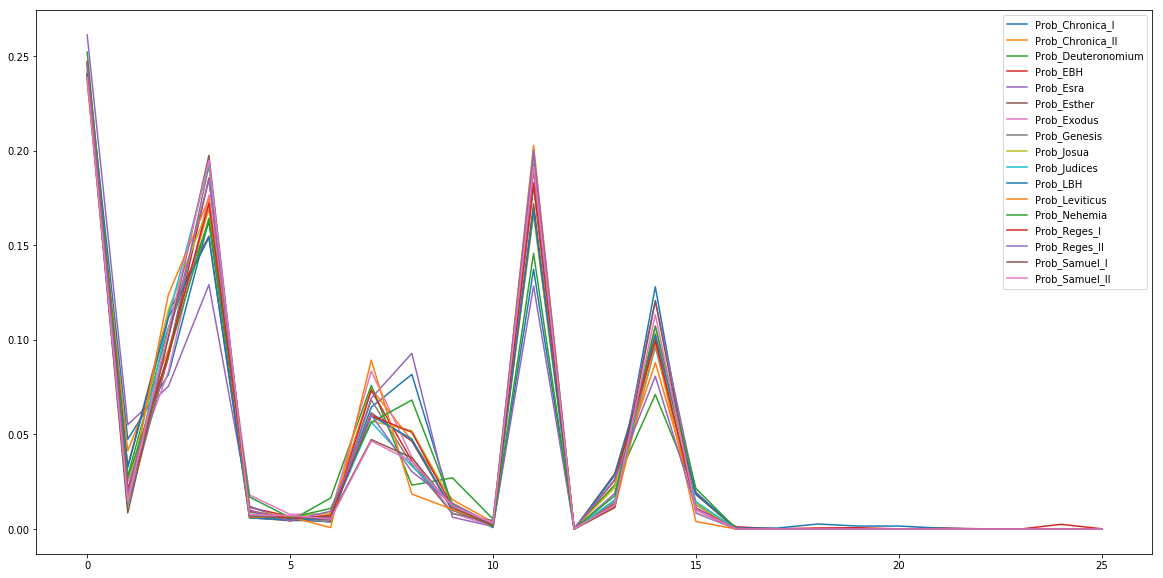

In [100]:
plt.figure(figsize= (20,10))
for column in df_probs:
    dfCol = df_probs[column]
    #dfCol = dfCol.sort_values(ascending=False)
    plt.plot(dfCol.values, label = column)
plt.legend(loc='upper right',  prop={'size': 10})
plt.show()

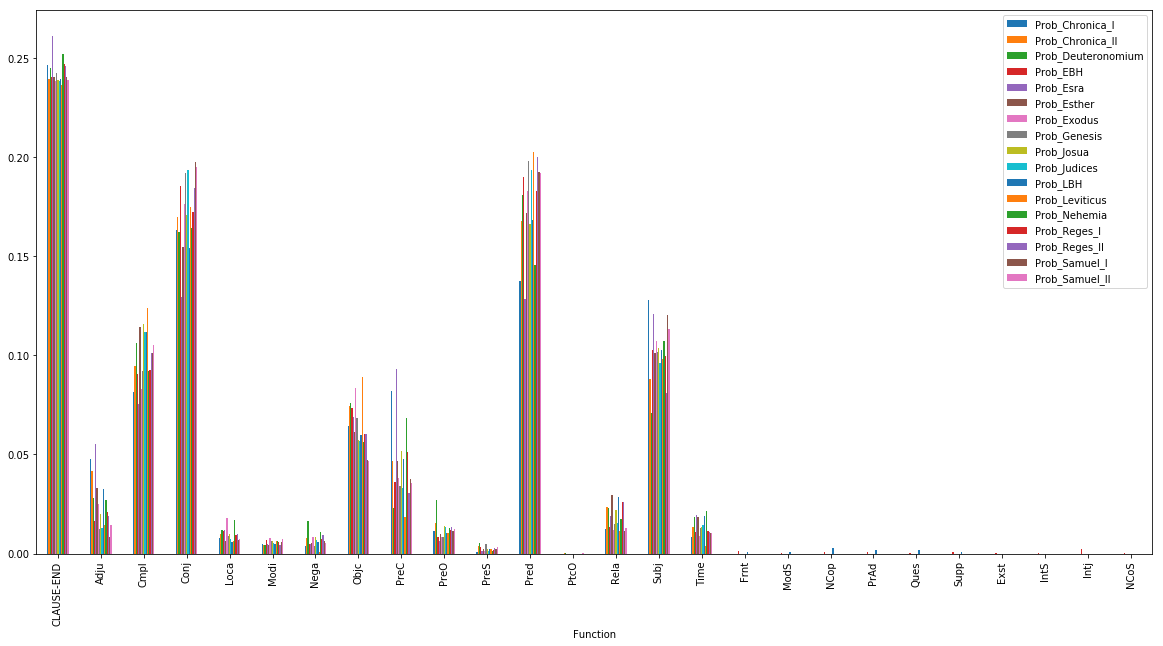

In [105]:
plt.figure(figsize = (200,10))
df_probs
df_probs.plot(kind='bar', figsize=(20,10))
plt.show()